In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split as data_split
from sklearn.datasets import load_breast_cancer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Neural Network

In [2]:
class DeepForward:
    def __init__(self,layer_dims,activations):
        #input - dims_arr, a list of the nodes in each layer
        #output- generates a list containing dimensions of the parameters
        def gen_dims(dims_arr):
            layers = []
            for i in range(len(dims_arr) - 1):
                dim = (dims_arr[i+1],dims_arr[i])
                layers.append(dim)
            return layers        
       
        self._forward_data  = {"a":[],"w":[],"b":[],"z":[]}
        self._backward_data = {"da":[],"dw":[],"db":[],"dz":[]}
        self._layer_dims    = gen_dims(layer_dims) 
        self._activations   = activations
        self._net_depth     = len(self._layer_dims)
        self._train_loss    = []
        self._test_loss     = []
        self._train_acc     = []
        self._test_acc      = []
        
        #intialize parameters
        for i in range(self._net_depth):
            dimen      = self._layer_dims[i]
            b_dimen    = (dimen[0],1)
            self._forward_data["w"].append(np.random.random(dimen))
            self._forward_data["b"].append(np.random.random(b_dimen))
            
            
    
    def __repr__(self):
        #displays the dimensions of each layer
        display_str = ""
        
        def act_name(x):
            if x == 0:
                return "sigmoid"
            elif x == 1:
                return "relu"
            else:
                return "tanh"
        
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        act = list(map(act_name,self._activations))
        
        for i in range(self._net_depth):
            display_str += f"Layer {i}- Weight dims:{w[i].shape}, bias dims:{b[i].shape} activation: {act[i]}\n"
        return display_str
    
    def print_data_shape(self,data_type):
        #print the shape of every data stored
        #data_type is either backward_data or forward_data
        data_type = "_"+data_type
        info      = self.__dict__[data_type]
        i = 0
        for k,v in info.items():
            for j in range(len(info[k])):
                if data_type == "_backward_data" and i == 0:
                    print(f"Layer {j+1} - {k}{j+1} dims:{info[k][j].shape}")
                else:    
                    print(f"Layer {j}- {k}{j} dims:{info[k][j].shape}")
            print("\n")
            i += 1
    
    def activation(self,z,act_type):
        #calculate activations
        if act_type == 0:
            return 1/(1+np.exp(-z))
        
        if act_type == 1:
            return np.maximum(z,0)
    
    
    def gradient(self,z,act_type):
        #calculate gradients
          if act_type == 0:
            a = 1/(1+np.exp(-z))
            return a*(1-a)

          if act_type == 1:
            return (z > 0).astype(float)
            
        
    def forward(self,X):
        #all z and a must be deleted before forward pass 
        a   = self._forward_data["a"] = []
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        z   = self._forward_data["z"] = []
        act = self._activations
        self._forward_data["a"].append(X.T)
        
        #perform forward pass for all layers
        for i in range(self._net_depth):
            z_new = w[i].dot(a[i]) + b[i]
            z.append(z_new)
            a_new = self.activation(z_new,act[i])
            a.append(a_new)
        
        return self
    
    def bce_loss(self,y,pred):
        #calculate binary cross entropy loss
        loss = -(y*np.log(pred) + (1-y)*np.log(1-pred))
        return np.mean(loss)
        
    
    def backward(self,y,loss_type = 0):
        y   = y.reshape(1,-1)
        a   = self._forward_data["a"]
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        z   = self._forward_data["z"]
        da,dw,db,dz = [],[],[],[]
        act = self._activations
        
        #function to reverse the order in which data was stored in a list
        def reorder(arr,dim):
            order = list(reversed(range(dim)))
            return [arr[i] for i in order]
        
        #loss 0 is BCE loss
        if loss_type == 0:
            da_last = np.divide(1-y,1-a[-1]) - np.divide(y,a[-1])
            da.append(da_last)
        
        #perform backpropagation for every layer
        for i in reversed(range(self._net_depth)):
            dz_new = da_last * self.gradient(z[i],act[i])
            dw_new = dz_new.dot(a[i].T)
            db_new = np.mean(dz_new,axis=1,keepdims=1)
            
            #store gradients in list
            dz.append(dz_new)
            dw.append(dw_new)
            db.append(db_new)
            
            #do not calcuate update for input data (X or a[0])
            if i != 0:
                da_new  = w[i].T.dot(dz_new)
                da_last = da_new
                da.append(da_new)
         
        #reorder the sequence in which gradients are stored 
        self._backward_data["dz"] = reorder(dz,len(dz))
        self._backward_data["dw"] = reorder(dw,len(dw))
        self._backward_data["db"] = reorder(db,len(db))
        self._backward_data["da"] = reorder(da,len(da))
        return self
    
    def update(self,lr):
        w   = self._forward_data["w"]
        b   = self._forward_data["b"]
        dw  = self._backward_data["dw"] 
        db  = self._backward_data["db"]
        
        #perform batch gradient descent
        for i in range(len(w)):
            w[i] -= lr * dw[i]
            b[i] -= lr * db[i]
            
        return self
    
    
    def train(self,X,y,Xt,yt,lr,epochs,freq):
        for epoch in range(epochs):
            #perform back propagation
            self.forward(X)
            pred = self._forward_data["a"][-1]
            loss = self.bce_loss(y,pred)
            self._train_loss.append(loss)
            self.backward(y)
            self.update(lr)
            
            #predictions and evaluations for train set
            self.forward(X)
            pred = self._forward_data["a"][-1]
            acc = self.accuracy(y,pred)
            self._train_acc.append(acc)
            
            #predictions and evaluations for test set
            self.forward(Xt)
            pred = self._forward_data["a"][-1]
            loss = self.bce_loss(yt,pred)
            acc = self.accuracy(yt,pred)
            self._test_loss.append(loss)
            self._test_acc.append(acc)
            
            #print stats
            if (epoch+1)%freq == 0:
                print(f"epoch:{epoch+1:2d} train loss:{self._train_loss[-1]:.3f} train acc:{self._train_acc[-1]:.3f}%")
                print(f"epoch:{epoch+1:2d} test loss:{self._test_loss[-1]:.3f} test acc:{self._test_acc[-1]:.3}%\n")
            
            #zero gradients and activations
            if epoch!= epochs-1:
                self._forward_data["a"]  = []
                self._forward_data["z"]  = []
                self._backward_data = {"da":[],"dw":[],"db":[],"dz":[]}
            
        return self
    
    
    def accuracy(self,y,pred):
        pred = (pred>0.5).astype(int)
        return (np.mean(y == pred)).astype("float") * 100
    
    
    def plot_losses(self,n):
        plt.figure(n)
        plt.plot(np.arange(len(self._train_loss)) + 1 , self._train_loss)
        plt.plot(np.arange(len(self._test_loss)) + 1 , self._test_loss)
        plt.xlabel("Epochs")
        plt.ylabel("Binary Cross Entropy Loss")
        plt.title("Binary Cross Entropy Loss vs iterations")
        plt.legend(['Train loss', 'Test loss'])
        
    def plot_accuracy(self,n):
        plt.figure(n)
        plt.plot(np.arange(len(self._train_acc)) + 1 , self._train_acc)
        plt.plot(np.arange(len(self._test_acc)) + 1 , self._test_acc)
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs iterations")
        plt.legend(['Train Accuracy', 'Test Accuracy'])

## Moon Dataset

Shape of X_train : (1500, 2)
Shape of X_test  : (500, 2)
Shape of y_train : (1500,)
Shape of X_test  : (500,)


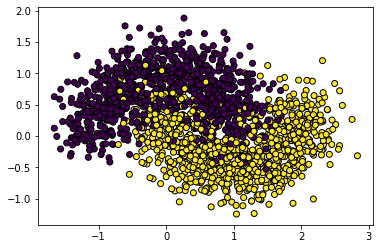

In [3]:
#generate moon data
X_moon,y_moon = make_moons(n_samples= 2000, shuffle=True, noise=0.3 ,random_state=5)
#plot moon data
plt.scatter(X_moon[:,0],X_moon[:,1], c=y_moon, edgecolors='k')

#split data
X_train, X_test, y_train, y_test = data_split(
    X_moon, y_moon,test_size=0.25, random_state=30)

#standardize moon data
scaler = preprocessing.StandardScaler().fit(X_moon)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test  : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of X_test  : {y_test.shape}")

In [4]:
layer_dims  = [2,2,2,1]
activations = [1,1,0]
model = DeepForward(layer_dims,activations)
model.train(X_train,y_train,X_test,y_test,lr=0.001,epochs=100,freq=10)

epoch:10 train loss:0.712 train acc:50.267%
epoch:10 test loss:0.711 test acc:49.2%

epoch:20 train loss:0.564 train acc:50.267%
epoch:20 test loss:0.547 test acc:49.2%

epoch:30 train loss:0.451 train acc:85.267%
epoch:30 test loss:0.438 test acc:85.8%

epoch:40 train loss:0.406 train acc:85.333%
epoch:40 test loss:0.399 test acc:86.0%

epoch:50 train loss:0.384 train acc:85.867%
epoch:50 test loss:0.368 test acc:87.6%

epoch:60 train loss:0.371 train acc:85.867%
epoch:60 test loss:0.355 test acc:87.4%

epoch:70 train loss:0.364 train acc:85.867%
epoch:70 test loss:0.349 test acc:87.0%

epoch:80 train loss:0.360 train acc:86.000%
epoch:80 test loss:0.343 test acc:87.2%

epoch:90 train loss:0.358 train acc:85.867%
epoch:90 test loss:0.339 test acc:87.4%

epoch:100 train loss:0.354 train acc:85.800%
epoch:100 test loss:0.337 test acc:87.0%



Layer 0- Weight dims:(2, 2), bias dims:(2, 1) activation: relu
Layer 1- Weight dims:(2, 2), bias dims:(2, 1) activation: relu
Layer 2- Weight dims:(1, 2), bias dims:(1, 1) activation: sigmoid

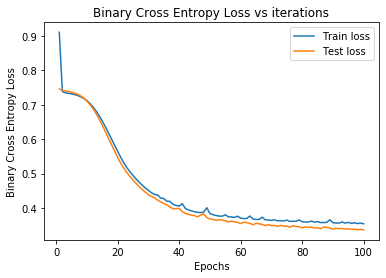

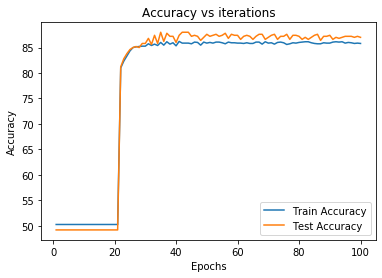

In [5]:
model.plot_losses(1)
model.plot_accuracy(2)

## Breast Cancer Dataset

In [6]:
data   = load_breast_cancer()
X_data = data.data
y_data = data.target

#split data
X_train, X_test, y_train, y_test = data_split(
    X_data, y_data,test_size=0.25, random_state=30)

#standardize moon data
scaler = preprocessing.StandardScaler().fit(X_data)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test  : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of X_test  : {y_test.shape}")

Shape of X_train : (426, 30)
Shape of X_test  : (143, 30)
Shape of y_train : (426,)
Shape of X_test  : (143,)


In [7]:
layer_dims  = [30,30,1]
activations = [0,0]
model = DeepForward(layer_dims,activations)
model.train(X_train,y_train,X_test,y_test,lr=1e-4,epochs=80,freq=10)

epoch:10 train loss:4.329 train acc:62.441%
epoch:10 test loss:3.998 test acc:63.6%

epoch:20 train loss:2.925 train acc:62.441%
epoch:20 test loss:2.665 test acc:63.6%

epoch:30 train loss:1.554 train acc:62.441%
epoch:30 test loss:1.372 test acc:63.6%

epoch:40 train loss:0.607 train acc:62.441%
epoch:40 test loss:0.556 test acc:62.9%

epoch:50 train loss:0.458 train acc:88.028%
epoch:50 test loss:0.441 test acc:90.2%

epoch:60 train loss:0.443 train acc:87.559%
epoch:60 test loss:0.427 test acc:90.2%

epoch:70 train loss:0.438 train acc:87.324%
epoch:70 test loss:0.423 test acc:89.5%

epoch:80 train loss:0.436 train acc:87.324%
epoch:80 test loss:0.421 test acc:90.2%



Layer 0- Weight dims:(30, 30), bias dims:(30, 1) activation: sigmoid
Layer 1- Weight dims:(1, 30), bias dims:(1, 1) activation: sigmoid

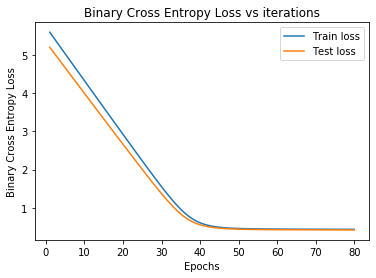

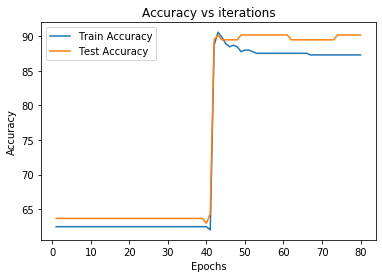

In [8]:
model.plot_losses(1)
model.plot_accuracy(2)